# Working Demo - Individual whale recognition model 
***This model needs to run on GPU, originally run in a Kaggle notebook with GPU P100***  
This model attempts to identify individual whales from their images. The dataset can be found at https://www.kaggle.com/datasets/engdan/happywhale-images-256-by-256.
This script defines 2 models.
1. A model to identify whales and dolphins using a CNN 
2. A model to identify whales and dolphins using pre-trained weights from VGG16 with added dense layers

In [8]:
import numpy as np
import pandas as pd
import keras
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [9]:
import os 
 
os.chdir('/Users/jessicakahn/Documents/Harvard DL/final_project/1. Individual Model Demo') 
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /Users/jessicakahn/Documents/Harvard DL/final_project/1. Individual Model Demo


#### Run the below cell if only zip file is present, otherwise skip this cell

In [41]:
!unzip *.zip

Archive:  sample_whale_files.zip
   creating: sample_whale_files/
  inflating: __MACOSX/._sample_whale_files  
  inflating: sample_whale_files/2bc5b795e2125c.jpg  
  inflating: __MACOSX/sample_whale_files/._2bc5b795e2125c.jpg  
  inflating: sample_whale_files/18e4767268f63d.jpg  
  inflating: __MACOSX/sample_whale_files/._18e4767268f63d.jpg  
  inflating: sample_whale_files/a1a50b91755180.jpg  
  inflating: __MACOSX/sample_whale_files/._a1a50b91755180.jpg  
  inflating: sample_whale_files/4b4d552aa6487f.jpg  
  inflating: __MACOSX/sample_whale_files/._4b4d552aa6487f.jpg  
  inflating: sample_whale_files/a593ae081ebb8f.jpg  
  inflating: __MACOSX/sample_whale_files/._a593ae081ebb8f.jpg  
  inflating: sample_whale_files/dd5207e097a98c.jpg  
  inflating: __MACOSX/sample_whale_files/._dd5207e097a98c.jpg  
  inflating: sample_whale_files/6cf22b5414d15d.jpg  
  inflating: __MACOSX/sample_whale_files/._6cf22b5414d15d.jpg  
  inflating: sample_whale_files/55631f305c1e68.jpg  
  inflating: __MA

In [10]:
# Read in the IDs of individual whales and join to image paths
train_ids = pd.read_csv('train.csv')
train_dir = 'sample_whale_files/'
im_list = os.listdir(train_dir)
train_df = pd.DataFrame(im_list, columns=['image'])
train_df = train_df.merge(train_ids, on='image', how='left')
train_df["image_path"] = train_df["image"].apply(lambda x: train_dir  + x)

In [11]:
# train_df.shape

In [47]:
from pathlib import Path

def make_folders(path):
    """
    This function creates separate folders for each unique id,
    which will have 1 or more images per folder
    """
    mappings = train_df.groupby('individual_id')['image'].apply(list).to_dict()
    for folder, file_list in mappings.items():
        for imfile in file_list:
            imfile = Path(path.joinpath(imfile))
            Path(path.joinpath(folder)).mkdir(parents=True, exist_ok=True)
            path = Path(path.joinpath())
            try:
                imfile.rename(path / folder / imfile.name)
            except FileNotFoundError:
                print(f"Couldn't find {imfile.stem} in source folder")

#### Skip the below cell if file structure is already set up

In [48]:
train_path = Path(train_dir)
make_folders(train_path)

#### Start here if file structure is fixed

In [12]:
# I found this helper function online to use as a wrapper
def preprocess_input_vgg(x):
    """Wrapper around keras.applications.vgg16.preprocess_input()
    to make it compatible for use with keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument.
    
    Parameters
    ----------
    x : a numpy 3darray (a single image to be preprocessed)
    
    Note we cannot pass keras.applications.vgg16.preprocess_input()
    directly to to keras.preprocessing.image.ImageDataGenerator's
    `preprocessing_function` argument because the former expects a
    4D tensor whereas the latter expects a 3D tensor. Hence the
    existence of this wrapper.
    
    Returns a numpy 3darray (the preprocessed image).
    
    """
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]

In [13]:
def plot_history(history, nepochs, metric):
    """ Helper function to plot accuracy or loss after model training """
    train_acc = history.history[metric]
    test_acc = history.history['val_'+metric]

    plt.figure(figsize=(16,6))
    plt.plot(range(1,nepochs+1), train_acc, 'b', label='train'+metric,color="blue")
    plt.plot(range(1,nepochs+1), test_acc, 'b', label='test'+metric,color="red")

    #plt.ylim((0, 0.0001))
    plt.title('CNN: max(val_{}) = '.format(metric) + str(round(max(test_acc),6)),fontsize=16)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend(loc = 'upper right',fontsize=16)
    # plt.ylim(0,0.06)

    plt.show()

In [14]:
px = 128
bs = 32
train_datagen = ImageDataGenerator(
#                                     preprocessing_function=preprocess_input_vgg,
                                rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)


train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(px, px), 
                                            #    color_mode='rgb',
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data = test_datagen.flow_from_directory(train_dir, 
                                           target_size=(px, px), 
                                        #    color_mode='rgb',
                                           batch_size=bs, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 2478 images belonging to 1869 classes.
Found 45 images belonging to 1869 classes.


In [15]:
model_in = Sequential()

model_in.add(Conv2D(filters=32, kernel_size = (5,5), strides = (1, 1), input_shape = (128, 128, 3)))
model_in.add(BatchNormalization(axis = 3))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((2, 2)))

model_in.add(Conv2D(filters=64, kernel_size = (4, 4), strides = (1,1)))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((3, 3)))

model_in.add(Conv2D(filters=128, kernel_size = (3, 3), strides = (1,1)))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((2,2)))

model_in.add(Conv2D(filters=256, kernel_size = (2, 2), strides = (1,1)))
model_in.add(Activation('relu'))
model_in.add(MaxPooling2D((2,2)))
model_in.add(Dropout(0.5))

# model_in.add(Conv2D(filters=300, kernel_size = (3, 3), strides = (1,1)))
# model_in.add(Activation('relu'))
# model_in.add(MaxPooling2D((2,2)))

model_in.add(Flatten())
# model_in.add(Dense(512, activation="relu"))
# model_in.add(Dropout(0.2))

model_in.add(Dense(1869, activation='softmax')) # Number of species

model_in.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_in.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 124, 124, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 activation_1 (Activation)   (None, 59, 59, 64)        0

In [16]:
# Fit the model
rec_history = model_in.fit(
      train_data,
#       steps_per_epoch=100,
      epochs=5,
      validation_data=val_data
#       ,validation_steps=50
      )

Epoch 1/5
78/78 [==============================] - 88s 1s/step - loss: 7.5620 - accuracy: 0.0065 - val_loss: 7.4928 - val_accuracy: 0.1111
Epoch 2/5
78/78 [==============================] - 82s 1s/step - loss: 7.5295 - accuracy: 0.0073 - val_loss: 7.4133 - val_accuracy: 0.1111
Epoch 3/5
78/78 [==============================] - 80s 1s/step - loss: 7.5026 - accuracy: 0.0081 - val_loss: 6.7549 - val_accuracy: 0.1111
Epoch 4/5
78/78 [==============================] - 83s 1s/step - loss: 7.4586 - accuracy: 0.0073 - val_loss: 6.6043 - val_accuracy: 0.0889
Epoch 5/5
78/78 [==============================] - 84s 1s/step - loss: 7.4427 - accuracy: 0.0093 - val_loss: 6.2192 - val_accuracy: 0.1111


/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_34441/1920935807.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), train_acc, 'b', label='train'+metric,color="blue")
/var/folders/4j/5szy6qkj5m96kf2gjwkk0dv80000gn/T/ipykernel_34441/1920935807.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(1,nepochs+1), test_acc, 'b', label='test'+metric,color="red")


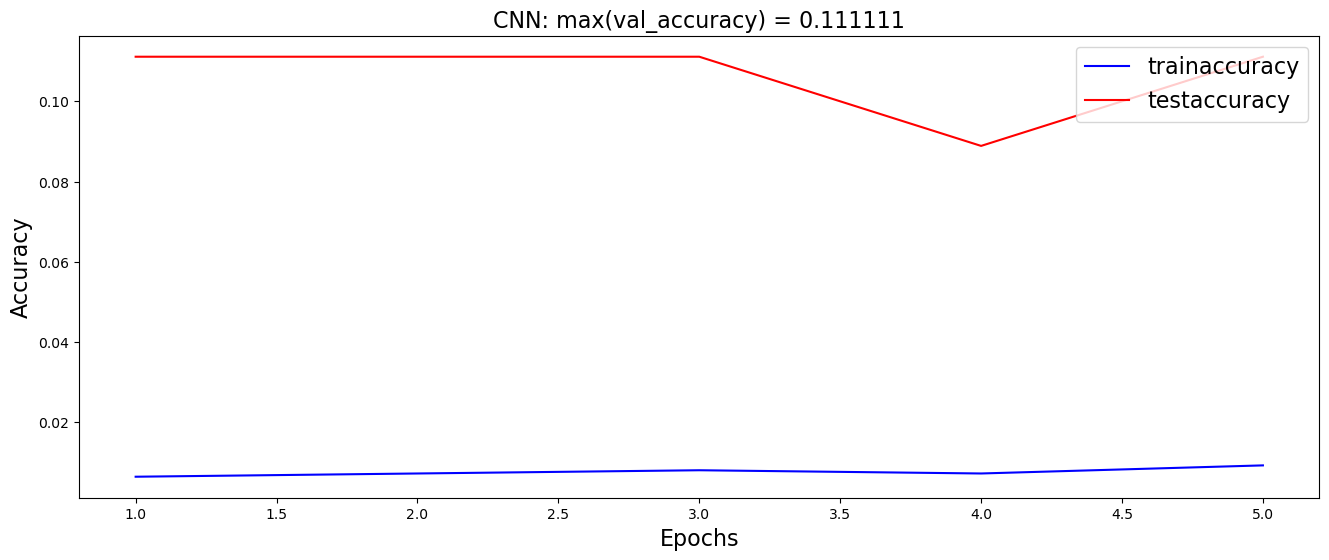

In [18]:
plot_history(rec_history, 5, 'accuracy')

### Attempt to use transfer learning
Load in the weight from VGG16 and make only the last layer trainable.

In [19]:
px = 128
bs = 32
train_datagen_vgg = ImageDataGenerator(
                                    preprocessing_function=preprocess_input_vgg,
                                rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)  # val 20%
test_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                      rescale=1./255,
                                  validation_split=0.2)


train_data_vgg = train_datagen_vgg.flow_from_directory(train_dir, 
                                               target_size=(px, px), 
                                            #    color_mode='rgb',
                                               batch_size=bs, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

val_data_vgg = test_datagen_vgg.flow_from_directory(train_dir, 
                                           target_size=(px, px), 
                                        #    color_mode='rgb',
                                           batch_size=bs, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 2478 images belonging to 1869 classes.
Found 45 images belonging to 1869 classes.


In [20]:
conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=(128,128,3))

In [21]:
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
# top_model = Dense(1072, activation='relu')(top_model)
# top_model = Dropout(0.5)(top_model)
output_layer = Dense(1869, activation='softmax')(top_model)

In [22]:
model3 = Model(inputs=conv_base.input, outputs=output_layer)
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# This is very slow without GPU
history = model3.fit(
        train_data_vgg,
        # steps_per_epoch=16,
        # steps_per_epoch=2000 // 
        batch_size=bs,
        epochs=10
        ,validation_data=val_data_vgg
#         ,steps_per_epoch=1400,
#          validation_steps=170
        )